# CLICKED VS DELETED INTERACTIONS

## Simple comparison between the pairs (user, item) that have had interaction 4 (deleted) versus interaction 1 (clicked)

This notebook tries to get insights into why users delete job notifications and why they click on job offers:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Import all the interactions of type "delete"
folderData = 'data/'
deleted_interactions = pd.read_csv(folderData + 'interactions_deleted.csv')
deleted_interactions.head()

,user_id,item_id,interaction_type,created_at
0,321946,560,4,1484925131
1,1300778,560,4,1484302470
2,1555094,560,4,1484592137
3,61911,890,4,1484425678
4,856138,890,4,1483611369


In [3]:
# Import all the interactions of type "replied"
clicked_interactions = pd.read_csv(folderData + 'interactions_clicked.csv')
clicked_interactions.head()

,user_id,item_id,interaction_type,created_at
0,2082156,80,1,1484299172
1,1934123,140,1,1486388563
2,1320213,240,1,1479409825
3,297303,310,1,1484817366
4,1635596,310,1,1486370081


Do we have (user, item) pairs that are common between both groups?

In [4]:
intersection = pd.merge(deleted_interactions, clicked_interactions, how='inner', on=['user_id', 'item_id'])

In [5]:
intersection.head()

,user_id,item_id,interaction_type_x,created_at_x,interaction_type_y,created_at_y
0,702758,890,4,1483609071,1,1483605457
1,421317,890,4,1483449509,1,1483445814
2,232940,890,4,1484560432,1,1486385308
3,3003,930,4,1479670079,1,1479666477
4,1622200,1600,4,1484150849,1,1484147190


Drop the intersections from deleted_interactions and clicked_interactions

In [6]:
idx = deleted_interactions['user_id'].isin(intersection['user_id']) & deleted_interactions['item_id'].isin(intersection['item_id'])
deleted_interactions = deleted_interactions[~idx]

In [7]:
idx = clicked_interactions['user_id'].isin(intersection['user_id']) & clicked_interactions['item_id'].isin(intersection['item_id'])
clicked_interactions = clicked_interactions[~idx]

From the intersections, let's check which interaction was last, in order to add it again to the corresponding variable. We assume that someone who first deletes and then clicks, is like clicking, and if someone first clicks and then deletes, is like deleting.

In [8]:
idx = intersection[['created_at_x', 'created_at_y']].max(axis=1)==intersection.created_at_x
idx.value_counts()

True     55498
False     1451
dtype: int64

True means delete after click, and False the opposite

In [9]:
aux = intersection.loc[idx, ['user_id', 'item_id', 'interaction_type_x','created_at_x']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
deleted_interactions = pd.concat([deleted_interactions, aux], ignore_index=True)

In [10]:
aux = intersection.loc[~idx, ['user_id', 'item_id', 'interaction_type_y','created_at_y']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
clicked_interactions = pd.concat([clicked_interactions, aux], ignore_index=True)

Import all users and items data

In [11]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [12]:
# Fill empties and transform the strings into a list
users.jobroles = users.jobroles.fillna('0').apply(lambda str: set(str.split(',')))
users.edu_fieldofstudies = users.edu_fieldofstudies.fillna('0').apply(lambda str: set(str.split(',')))

In [13]:
# Import all items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [14]:
# Fill empties and transform the strings into a list
items.title = items.title.fillna('0').apply(lambda str: set(str.split(',')))
items.tags = items.tags.fillna('0').apply(lambda str: set(str.split(',')))
items['created_at_dt'] = pd.to_datetime(items.created_at,unit='s', errors='coerce')

In [15]:
# Merge data sets. Find all the information of users and items that have an interaction of type 4
data_deleted = deleted_interactions.merge(users, on='user_id', how='inner')
data_deleted = data_deleted.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_deleted.head()

,user_id,item_id,interaction_type,created_at_user,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,region_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,321946,560,4,1484925131,"{4419072, 2904979, 3124810, 1050544, 362085}",0,0,0,de,0,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
1,1300778,560,4,1484302470,"{3460004, 2028066, 2180632, 2154744, 4504662, ...",3,4,3,de,1,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
2,1555094,560,4,1484592137,"{1745826, 2714822, 1408054, 4330980, 3614810, ...",2,0,16,de,9,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
3,321946,28540,4,1484925135,"{4419072, 2904979, 3124810, 1050544, 362085}",0,0,0,de,0,...,16,de,1,9,51.5,7.5,1,"{3797268, 3698446, 518708, 202201, 2950030, 36...",1484262000,2017-01-12 23:00:00
4,1555094,28540,4,1484592139,"{1745826, 2714822, 1408054, 4330980, 3614810, ...",2,0,16,de,9,...,16,de,1,9,51.5,7.5,1,"{3797268, 3698446, 518708, 202201, 2950030, 36...",1484262000,2017-01-12 23:00:00


In [16]:
# Remove interaction type
data_deleted.drop(['interaction_type'], axis=1, inplace=True)
data_deleted.shape

(705136, 29)

In [17]:
# Merge data sets. Find all the information of users and items that have an interaction of type 3
data_clicked = clicked_interactions.merge(users, on='user_id', how='inner')
data_clicked = data_clicked.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_clicked.head()

,user_id,item_id,interaction_type,created_at_user,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,region_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,2082156,80,1,1484299172,"{4099592, 924730, 2968849}",0,0,20,de,1,...,1,de,0,1,48.8,8.1,1,"{3275701, 4050466, 1339355, 910844, 258464, 41...",1483570800,2017-01-04 23:00:00
1,2082156,1057450,1,1484298688,"{4099592, 924730, 2968849}",0,0,20,de,1,...,20,de,1,2,49.5,11.1,1,"{2580855, 2377066, 261047, 1820491, 4098162, 3...",1484175600,2017-01-11 23:00:00
2,1297638,1057450,1,1484738526,"{4516410, 3500546, 2233665, 4015589, 4018408}",3,0,0,de,0,...,20,de,1,2,49.5,11.1,1,"{2580855, 2377066, 261047, 1820491, 4098162, 3...",1484175600,2017-01-11 23:00:00
3,2311914,1057450,1,1484473961,{4018408},0,0,20,de,6,...,20,de,1,2,49.5,11.1,1,"{2580855, 2377066, 261047, 1820491, 4098162, 3...",1484175600,2017-01-11 23:00:00
4,2118237,1057450,1,1484223195,{2126376},6,4,7,de,2,...,20,de,1,2,49.5,11.1,1,"{2580855, 2377066, 261047, 1820491, 4098162, 3...",1484175600,2017-01-11 23:00:00


In [18]:
# Remove interaction type
data_clicked.drop(['interaction_type'], axis=1, inplace=True)
data_clicked.shape

(6745673, 29)

In [19]:
print data_clicked.columns

Index([u'user_id', u'item_id', u'created_at_user', u'jobroles',
       u'career_level_user', u'discipline_id_user', u'industry_id_user',
       u'country_user', u'region_user', u'experience_n_entries_class',
       u'experience_years_experience', u'experience_years_in_current',
       u'edu_degree', u'edu_fieldofstudies', u'wtcj', u'premium', u'title',
       u'career_level_item', u'discipline_id_item', u'industry_id_item',
       u'country_item', u'is_payed', u'region_item', u'latitude', u'longitude',
       u'employment', u'tags', u'created_at_item', u'created_at_dt'],
      dtype='object')


In [20]:
# Select all users and items who have been involved with interaction 4
idx = users.user_id.isin(data_deleted.user_id)
users_not_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_deleted.item_id)
items_not_interesting = items.ix[idx].reset_index(drop=True)

In [21]:
# Select all users and items who have been involved with interaction 1
idx = users.user_id.isin(data_clicked.user_id)
users_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_clicked.item_id)
items_interesting = items.ix[idx].reset_index(drop=True)

# Let's study each one of the columns and compare the values between both groups to see if there are differences

## Career level

Which career level do users have? Does it match the career level asked at the job?

In [22]:
data_deleted.career_level_user.value_counts().sort_index().to_dict()

{0: 237155, 1: 5606, 2: 31468, 3: 253272, 4: 134197, 5: 20860, 6: 22578}

In [23]:
data_deleted.career_level_item.value_counts().sort_index().to_dict()

{1: 10079, 2: 33647, 3: 443580, 4: 184909, 5: 24194, 6: 8727}

In [24]:
data_clicked.career_level_user.value_counts().sort_index().to_dict()

{0: 3821574, 1: 48990, 2: 203204, 3: 1559334, 4: 736605, 5: 194620, 6: 181346}

In [25]:
data_clicked.career_level_item.value_counts().sort_index().to_dict()

{1: 157647, 2: 428566, 3: 4494499, 4: 1148644, 5: 210615, 6: 305702}

Lets only look at the data for which we know the career level (ignore case 0)

In [26]:
subset1 = data_deleted[data_deleted.career_level_user!=0]
n = float(len(subset1))
print np.sum(subset1.career_level_item==subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item>subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item<subset1.career_level_user)/n*100.0

55.9924441377
19.0520555322
24.9555003301


In [27]:
diff_career_level = subset1.career_level_user-subset1.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 19,
 -4: 77,
 -3: 1422,
 -2: 11836,
 -1: 75806,
 0: 262034,
 1: 88153,
 2: 21579,
 3: 6928,
 4: 108,
 5: 19}

Approximately 55% of interactions of type 4 have the same career level

In [28]:
subset2 = data_clicked[data_clicked.career_level_user!=0]
n = float(len(subset2))
print np.sum(subset2.career_level_item==subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item>subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item<subset2.career_level_user)/n*100.0

52.59233699
20.2010260255
27.2066369846


In [29]:
diff_career_level = subset2.career_level_user-subset2.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 71,
 -4: 564,
 -3: 8752,
 -2: 80058,
 -1: 501253,
 0: 1537852,
 1: 531257,
 2: 156824,
 3: 96469,
 4: 7399,
 5: 3600}

Not much differece in both groups

Conclusion:

    1. In both deleted and clicked interactions, the career level match behaves similarly


## Discipline id

Let's ask the same questions

In [30]:
data_deleted.discipline_id_user.value_counts().head()

0     464521
4      55343
5      34636
17     32180
3      20409
Name: discipline_id_user, dtype: int64

In [31]:
data_deleted.discipline_id_item.value_counts().head()

17    132902
5      69807
21     54857
3      54781
13     53081
Name: discipline_id_item, dtype: int64

In [32]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset1 = data_deleted[data_deleted.discipline_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.discipline_id_item==subset1.discipline_id_user)/n*100.0

44.3604929036


Having a discpline match doesn't seem so important when deleting a job

In [33]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset2 = data_clicked[data_clicked.discipline_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.discipline_id_item==subset2.discipline_id_user)/n*100.0

44.5489349968


It does not seem important either when clicking

Are particular disciplines more popular or less popular?

    1. Users

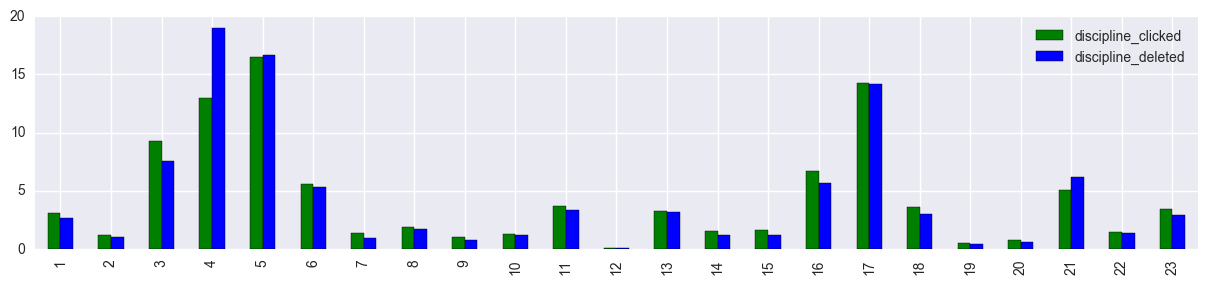

In [35]:
discipline_deleted = users_not_interested[users_not_interested.discipline_id!=0].discipline_id.value_counts()/len(users_not_interested[users_not_interested.discipline_id!=0])*100
discipline_clicked = users_interested[users_interested.discipline_id!=0].discipline_id.value_counts()/len(users_interested[users_interested.discipline_id!=0])*100
df = pd.DataFrame({'discipline_deleted':discipline_deleted, 'discipline_clicked':discipline_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

    2. items

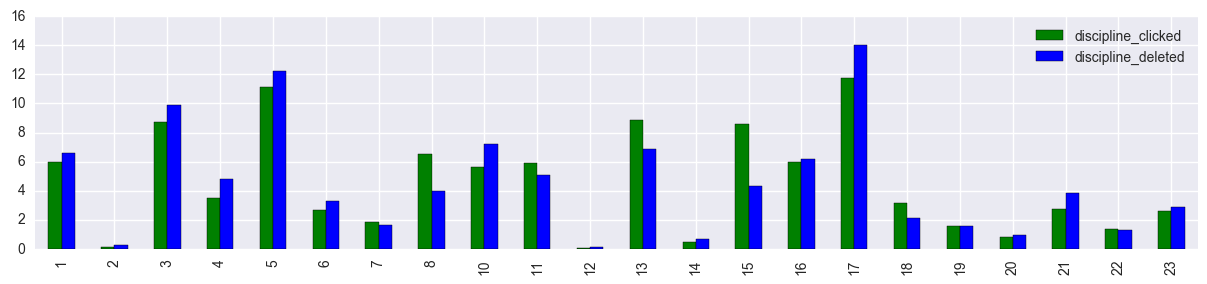

In [36]:
discipline_deleted = items_not_interesting[items_not_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_not_interesting[items_not_interesting.discipline_id!=0])*100
discipline_clicked = items_interesting[items_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_interesting[items_interesting.discipline_id!=0])*100
df = pd.DataFrame({'discipline_deleted':discipline_deleted, 'discipline_clicked':discipline_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

In [37]:
idx = subset1.discipline_id_item==subset1.discipline_id_user
subset1[idx].discipline_id_item.value_counts()/len(subset1[idx])*100

17    19.861717
5     19.641552
4     11.334295
3     10.519215
21     9.328449
16     6.342633
11     4.931702
1      3.904889
13     2.623246
6      2.306582
8      2.039574
23     1.324739
18     1.167344
15     0.896588
20     0.872229
7      0.864734
14     0.789784
19     0.381308
22     0.375686
2      0.314789
10     0.167700
12     0.011242
Name: discipline_id_item, dtype: float64

In [38]:
idx = subset2.discipline_id_item==subset2.discipline_id_user
subset2[idx].discipline_id_item.value_counts()/len(subset2[idx])*100

5     22.311703
17    17.276915
3     16.667040
16     8.482430
21     5.881064
11     4.877721
4      4.716335
1      3.920123
13     2.843844
6      2.568577
23     1.924313
7      1.536924
8      1.511172
18     1.345148
15     1.175285
14     1.052286
20     0.693687
22     0.369316
19     0.348203
2      0.337966
10     0.137394
12     0.022552
Name: discipline_id_item, dtype: float64

Conclusions

1. Both groips behave similar with the discipline id

    

## industry_id

In [39]:
data_deleted.industry_id_user.value_counts().head(n=5)

0     208269
14     93644
7      87239
16     58702
15     54801
Name: industry_id_user, dtype: int64

In [40]:
data_deleted.industry_id_item.value_counts().head(n=5)

16    200401
7      94083
3      63863
20     61178
9      44934
Name: industry_id_item, dtype: int64

In [41]:
data_clicked.industry_id_user.value_counts().head(n=5)

0     2562021
20    1050441
7      602675
16     374684
15     318846
Name: industry_id_user, dtype: int64

In [42]:
data_clicked.industry_id_item.value_counts().head(n=5)

16    1958620
7      825677
20     531491
3      491474
15     457167
Name: industry_id_item, dtype: int64

In [43]:
subset1 = data_deleted[data_deleted.industry_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.industry_id_item==subset1.industry_id_user)/n*100.0

19.8445459248


Very few interactions of type delete have a match of industry_id

In [44]:
subset2 = data_clicked[data_clicked.industry_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.industry_id_item==subset2.industry_id_user)/n*100.0

22.1034636724


similarly for interactions of type click, just a bit higher

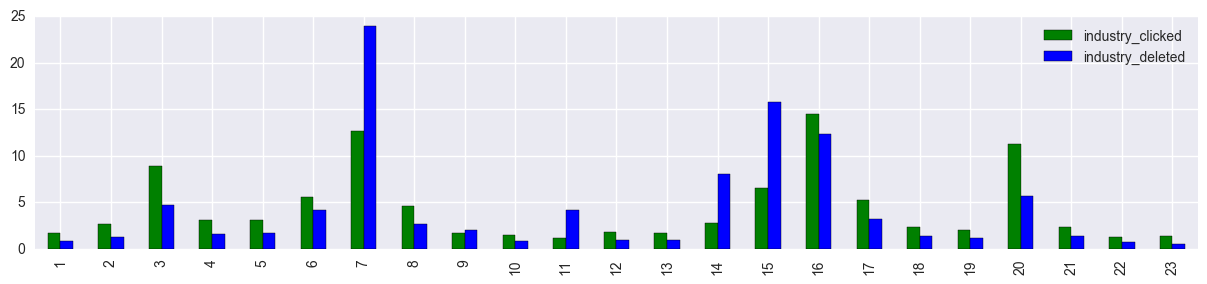

In [45]:
industry_deleted = users_not_interested[users_not_interested.industry_id!=0].industry_id.value_counts()/len(users_not_interested[users_not_interested.industry_id!=0])*100
industry_clicked = users_interested[users_interested.industry_id!=0].industry_id.value_counts()/len(users_interested[users_interested.industry_id!=0])*100
df = pd.DataFrame({'industry_deleted':industry_deleted, 'industry_clicked':industry_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

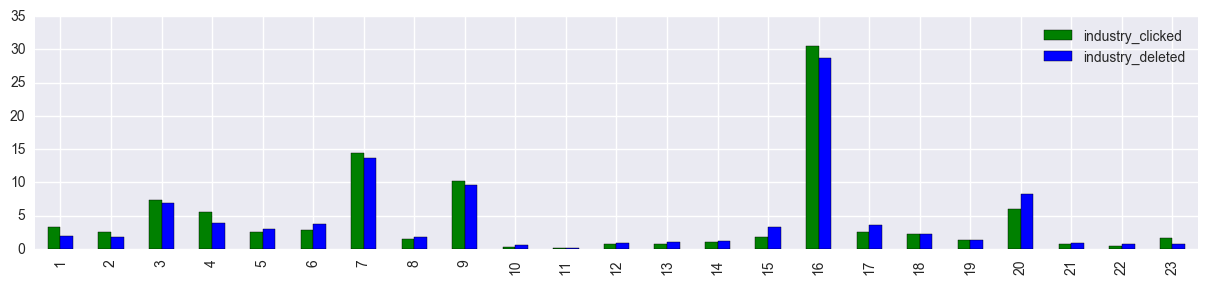

In [46]:
industry_deleted = items_not_interesting[items_not_interesting.industry_id!=0].industry_id.value_counts()/len(items_not_interesting[items_not_interesting.industry_id!=0])*100
industry_clicked = items_interesting[items_interesting.industry_id!=0].industry_id.value_counts()/len(items_interesting[items_interesting.industry_id!=0])*100
df = pd.DataFrame({'industry_deleted':industry_deleted, 'industry_clicked':industry_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions: 

    1. Industry_id match does not seem very relevant
    2. Users from industries 7, 14 and 15 delete more than click

## experience_n_entries_class

In [47]:
data_deleted.experience_n_entries_class.value_counts()/float(len(data_deleted))*100

3    57.131532
1    22.480911
2    20.387556
Name: experience_n_entries_class, dtype: float64

In [48]:
data_clicked.experience_n_entries_class.value_counts()/float(len(data_clicked))*100

3    43.667192
1    32.874867
2    23.457941
Name: experience_n_entries_class, dtype: float64

Conclusions: 

    From the deleted interactions, 60% of them corresponded to users with more than 5 entries in CV (level=3). However, from the replied interactions, only 44% corresponded to them. It seems like people with a lot of job experiences is not so interested in changing jobs. 

## experience_years_experience & experience_years_in_current

In [49]:
data_deleted.experience_years_experience.value_counts()/float(len(data_deleted))*100

7    27.686574
4    17.930725
5    17.367004
6    16.398397
0    15.019230
3     3.380199
2     1.742784
1     0.475086
Name: experience_years_experience, dtype: float64

In [50]:
data_clicked.experience_years_experience.value_counts()/float(len(data_clicked))*100

0    19.445058
4    19.153834
7    18.785034
5    18.541545
6    15.602417
3     4.948179
2     2.792145
1     0.731788
Name: experience_years_experience, dtype: float64

Conclusion:
1. 30% of deletions occur with users with more than 7 years of experience
2. Less than 4% of deletions occur with users with less than 4 years of experience

In [51]:
data_deleted.experience_years_in_current.value_counts()/float(len(data_deleted))*100

2    27.089951
1    17.595187
0    16.884402
4    14.832316
3    12.911694
5     5.368752
6     2.793362
7     2.524336
Name: experience_years_in_current, dtype: float64

In [52]:
data_clicked.experience_years_in_current.value_counts()/float(len(data_clicked))*100

2    26.083684
0    22.184918
4    14.186501
3    13.581239
1    13.410686
5     5.376409
6     3.089610
7     2.086953
Name: experience_years_in_current, dtype: float64

Conclusion:
    1. 27% of deletions occur when user has 2 years of experience in current job
    2. At the same time 26% of replies happen when user has 2 years of experience at current job
    3. Don't know what to do here...

## edu_degree

In [53]:
data_deleted.edu_degree.value_counts()/float(len(data_deleted))*100

0    63.989925
2    23.904608
1     9.057969
3     3.047497
Name: edu_degree, dtype: float64

In [54]:
data_clicked.edu_degree.value_counts()/float(len(data_clicked))*100

0    64.092137
2    20.998157
1    10.187345
3     4.722361
Name: edu_degree, dtype: float64

Conclusion:
    1. Majority of users in both groups have not specifed the edu_degree 

## field of studies

In [55]:
# Count how many times each field of study appears
field_of_studies_deleted = data_deleted.edu_fieldofstudies.apply(lambda x: list(x))
field_of_studies_replied = data_clicked.edu_fieldofstudies.apply(lambda x: list(x))

In [56]:
import itertools
field_of_studies_deleted = list(itertools.chain.from_iterable(field_of_studies_deleted.values.flatten()))
field_of_studies_replied = list(itertools.chain.from_iterable(field_of_studies_replied.values.flatten()))

In [57]:
from collections import Counter
{k: v/float(len(field_of_studies_deleted))*100 for k, v in dict(Counter(field_of_studies_deleted)).items()}

{'0': 45.48507260126306,
 '1': 0.3139549011345806,
 '2': 4.928019150085695,
 '3': 13.625952915812523,
 '4': 1.8669265508389796,
 '5': 8.750410377443846,
 '6': 0.9248033419587994,
 '7': 5.759502015050188,
 '8': 17.374411576909257,
 '9': 0.9709465695030749}

In [58]:
{k: v/float(len(field_of_studies_replied))*100 for k, v in dict(Counter(field_of_studies_replied)).items()}

{'0': 49.518907397173756,
 '1': 0.36990330918065084,
 '2': 4.237563542378176,
 '3': 12.465131924445924,
 '4': 1.5777525305398141,
 '5': 8.06520194548656,
 '6': 0.7744189798208971,
 '7': 4.136774432709437,
 '8': 18.02886651724268,
 '9': 0.8254794210221011}

Conclusions: 
    1. the distribution of field of studies is very similar between the two groups

## WTCJ

In [59]:
data_deleted.wtcj.value_counts()/len(data_deleted)*100

1    75.492245
0    24.507755
Name: wtcj, dtype: float64

In [60]:
data_clicked.wtcj.value_counts()/len(data_clicked)*100

1    79.79441
0    20.20559
Name: wtcj, dtype: float64

Conclusion:
    1. There is not a lot of difference between both groups, however there is slghtly more willingness to change jobs among the users who have clicked, compared to the ones who deleted

## premium

In [61]:
data_deleted.premium.value_counts()/len(data_deleted)*100

0    73.381589
1    26.618411
Name: premium, dtype: float64

In [62]:
data_clicked.premium.value_counts()/len(data_clicked)*100

0    80.763728
1    19.236272
Name: premium, dtype: float64

Conclusion:
1. Not much difference, but it seems that users who click normally are not premium

## employment

In [63]:
data_deleted.employment.value_counts()/float(len(data_deleted))*100

1    95.619285
2     2.204823
3     1.083479
4     1.064617
0     0.027796
Name: employment, dtype: float64

In [64]:
data_clicked.employment.value_counts()/float(len(data_clicked))*100

1    91.703882
2     5.706058
3     1.519211
4     1.050940
0     0.019909
Name: employment, dtype: float64

Conclusions: 
    1. Both groups have majority of jobs full time

## title & tag

In [65]:
data_deleted.title.head()

0    {3431606, 4330980, 579315, 3614810, 2714822}
1    {3431606, 4330980, 579315, 3614810, 2714822}
2    {3431606, 4330980, 579315, 3614810, 2714822}
3    {579315, 3431606, 4330980, 3614810, 2714822}
4    {579315, 3431606, 4330980, 3614810, 2714822}
Name: title, dtype: object

In [66]:
data_clicked.tags.head()

0    {3275701, 4050466, 1339355, 910844, 258464, 41...
1    {2580855, 2377066, 261047, 1820491, 4098162, 3...
2    {2580855, 2377066, 261047, 1820491, 4098162, 3...
3    {2580855, 2377066, 261047, 1820491, 4098162, 3...
4    {2580855, 2377066, 261047, 1820491, 4098162, 3...
Name: tags, dtype: object

In [67]:
def intersect(x):
    return x[0]&x[1]

Find the intersection between titles and tags

In [68]:
data_deleted['title_tag_match'] = data_deleted[['title', 'tags']].apply(intersect, axis=1)
data_clicked['title_tag_match'] = data_clicked[['title', 'tags']].apply(intersect, axis=1)

In [69]:
# Count how many titles
data_deleted['num_titles'] = data_deleted.title.apply(len)
data_deleted.num_titles.value_counts()/float(len(data_deleted))*100

3     20.790316
1     20.053153
2     17.702968
4     12.016264
5      9.706638
6      6.698282
7      4.402555
9      2.786129
8      2.742024
10     0.974138
11     0.922801
12     0.684974
14     0.264630
13     0.126642
15     0.072752
17     0.030491
16     0.017443
18     0.005673
19     0.001276
22     0.000709
20     0.000142
Name: num_titles, dtype: float64

In [70]:
# Count how many titles
data_clicked['num_titles'] = data_clicked.title.apply(len)
data_clicked.num_titles.value_counts()/float(len(data_clicked))*100

2     22.841679
1     21.649878
3     17.315025
4     10.648900
6      9.319619
5      7.931025
8      3.460811
7      2.907419
9      1.161530
14     0.894099
10     0.792345
12     0.705178
11     0.244824
13     0.061640
15     0.038128
17     0.010733
16     0.009236
18     0.005989
19     0.000786
20     0.000593
22     0.000504
23     0.000044
29     0.000015
Name: num_titles, dtype: float64

Conclusions:

1. Not much to extract... at the moment

## is_payed

In [71]:
data_deleted.is_payed.value_counts()/float(len(data_deleted))*100

1    69.524035
0    30.475965
Name: is_payed, dtype: float64

In [72]:
data_clicked.is_payed.value_counts()/float(len(data_clicked))*100

1    56.663094
0    43.336906
Name: is_payed, dtype: float64

Conclusions:
    1. It seems that for deleted interactions, 70 % of the posted jobs were payed for, however, when the user clicked to the posting only 56% of them were payed for.

## Geography

In [73]:
n = float(len(data_clicked))
print np.sum(data_clicked.country_item==data_clicked.country_user)/n*100.0

82.8938491386


In [74]:
n = float(len(data_deleted))
print np.sum(data_deleted.country_item==data_deleted.country_user)/n*100.0

86.1947198838


In [75]:
n = float(len(data_clicked))
print np.sum(data_clicked.region_item==data_clicked.region_user)/n*100.0

24.8478098479


In [76]:
n = float(len(data_deleted))
print np.sum(data_deleted.region_item==data_deleted.region_user)/n*100.0

22.4050395952


# Conclusions

I still need to think but some of the conclusions I have extracted here I believe can be converted into features for our classification problem. I will revise this later

# Possible extra features:

- career level match
- career level item < career level user
- industry match
- user industry is 7, 14, 23
- region and country match